In [2]:
import pandas as pd

In [3]:
# Read the CSV files into DataFrames
df = pd.read_csv("NEW_M_J.csv", parse_dates=True, index_col="datetime")

Merge of the two csv datasets plus a new one, expanding from November 1st 2023 to August 1st 2023 - May 15 2024
Source: https://www.visualcrossing.com/weather/weather-data-services#

In [4]:
df = df[['location', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase', 'conditions', 'description']]

# df = df[['location', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'cloudcover', 'visibility']]

In [5]:
beijing_city = df[df["location"] == "Beijing"]
berlin_city = df[df["location"] == "Berlin"]
London_city = df[df["location"] == "London"]
mexico_city = df[df["location"] == "Mexico City"]
moscow_city = df[df["location"] == "Moscow"]
ottawa_city = df[df["location"] == "Ottawa"]
paris_city = df[df["location"] == "Paris"]
rome_city = df[df["location"] == "Rome"]
washington_city = df[df["location"] == "Washington DC"]

In [6]:
beijing_city

,location,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions,description
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-01,Beijing,25.2,8.0,18.1,25.2,8.0,18.1,8.1,54.7,0.0,...,0.0,36.4,21.6,110.5,1009.6,54.2,10.4,0.35,Partially cloudy,Partly cloudy throughout the day.
2023-05-02,Beijing,29.0,15.8,22.3,27.9,15.8,22.1,10.4,48.9,0.0,...,0.0,37.4,21.6,133.7,1008.3,26.0,10.6,0.39,Partially cloudy,Partly cloudy throughout the day.
2023-05-03,Beijing,28.0,14.0,21.2,27.6,14.0,21.1,12.4,59.4,0.0,...,0.0,30.6,18.0,122.7,1011.3,62.2,10.1,0.42,Partially cloudy,Partly cloudy throughout the day.
2023-05-04,Beijing,22.0,15.0,17.8,22.0,15.0,17.8,14.0,79.1,0.1,...,0.0,28.8,14.4,99.7,1009.2,85.1,8.4,0.45,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...
2023-05-05,Beijing,19.0,16.7,17.8,19.0,16.7,17.8,9.5,61.9,1.1,...,0.0,46.8,28.8,5.6,1009.1,95.8,11.4,0.48,"Rain, Overcast",Cloudy skies throughout the day with rain clea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-03,Beijing,31.0,18.7,24.9,30.3,18.7,24.8,14.5,54.9,0.0,...,0.0,14.8,14.4,162.4,1004.8,65.7,22.9,0.90,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...
2024-07-04,Beijing,32.5,22.9,27.3,33.4,22.9,27.8,18.3,59.1,1.8,...,0.0,16.2,13.3,147.2,1004.0,63.3,23.4,0.94,"Rain, Partially cloudy",Clearing in the afternoon with rain clearing l...
2024-07-05,Beijing,36.4,23.1,29.5,37.7,23.1,30.1,18.2,52.9,1.1,...,0.0,24.1,16.2,182.7,1000.6,84.7,24.1,0.97,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...


The workflow:
1) Understand the problem -- find next day's high/low temp; I have data on humidity, temperature, wind speed, etc
2) Identify Key Factors -- What are the independent variables (hint #1) and my dependent variables
3) Hypothesis -- _ significantly impacts 
4) Translate Hypo => Testable Statements -- Null/Alternate Hypothesis (this is an example, I had to do this in school, maybe it will help maybe not)
5) Design the Experiment -- Data collection/cleaning, model selection, evaluation metrics (Research here)
6) Analsys -- train the models, evaluate results (expected temp from your model vs actual temp), testing
7) Success 

- What determines the next day's high and low temperature for each location?
- What do you see from the data at first glance that might impact this?
- How would you need to organize and clean your data?
- Is your model 'universal', meaning does it apply to every location the same (no variance) when it comes to these predictions?
- If not, what factors impact your model?
- What tools or metrics will you need to use to account for these changes?
- Is your model accurate? What causes the inaccuracy, if any?

4) Translate Hypo => Testable Statements -- Null/Alternate Hypothesis (this is an example, I had to do this in school, maybe it will help maybe not)

In [7]:
df_numerical = df[['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase']]

5) Design the Experiment -- Data collection/cleaning, model selection, evaluation metrics (Research here)

- I used a heatmap to visualize the corralatioin between dew point and temperature

- Check Regression assumptions
- Seperate dataframes per location
- R2 and Adjusted R2
- - sns.heatmap Pearson correlation test
- Feature selection
- Hypothesis -- significantly impacts
- Cross validation (Model selection)
- Training and evaluation

The true purpose of regression is to seperate the total variance in lowtemp and hightemp from the variance explained by dew and the variance that is still unexplained.

- Positive coefficients for dew, precip, precipcover suggest these factors increase tempmax.
- Negative coefficients for humidity, windgust, cloudcover, visibility suggest these factors decrease tempmax.

 Hyperparameter tuning to optimize Ridge - Done

# Training the Model - use pipelines - prediction function

In [8]:
feat_df = df_numerical[['dew', 'humidity', 'precip', 'precipcover', 'windgust', 'cloudcover', 'visibility']]
feat_df.corr()

,dew,humidity,precip,precipcover,windgust,cloudcover,visibility
dew,1.000000,0.221538,0.161513,0.036930,-0.033037,0.077251,0.033898
humidity,0.221538,1.000000,0.307238,0.537053,-0.020325,0.546886,-0.009104
precip,0.161513,0.307238,1.000000,0.497129,0.176784,0.261994,-0.086670
precipcover,0.036930,0.537053,0.497129,1.000000,0.252450,0.508023,-0.013196
windgust,-0.033037,-0.020325,0.176784,0.252450,1.000000,0.139573,0.036167
cloudcover,0.077251,0.546886,0.261994,0.508023,0.139573,1.000000,0.077255
visibility,0.033898,-0.009104,-0.086670,-0.013196,0.036167,0.077255,1.000000


Text(95.72222222222221, 0.5, 'Features')

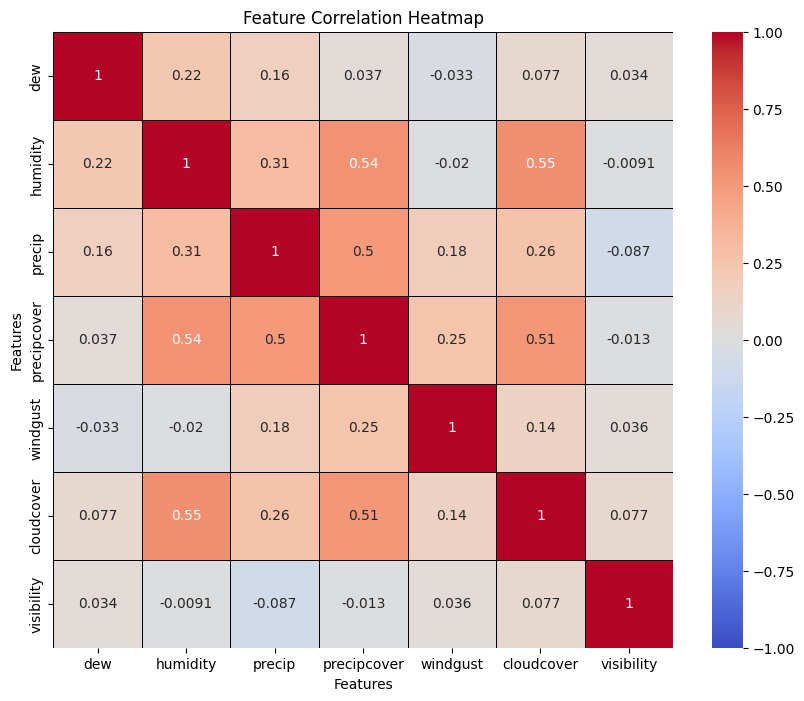

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

corr_matrix = feat_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')

# Add titles and labels
plt.title('Feature Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

Original hypothesis: A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography.

# New hypothesis:
# Translate Hypo => Testable Statements -- Null/Alternate Hypothesis

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features = ['dew', 'humidity', 'precip', 'precipcover', 'windgust', 'cloudcover', 'visibility']

# Function to calculate R-squared values for the specified features against a target
def calculate_r_squared(group, target, features):
    r_squared_dict = {}
    for feature in features:
        X = group[[feature]]
        y = group[target]
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r_squared = r2_score(y, y_pred)
        r_squared_dict[feature] = r_squared
    return r_squared_dict

# Group by 'location' column
grouped_df = df.groupby('location')

# Initialize a dictionary to hold R-squared values for each location
r_squared_results = {}

# Features to be evaluated

# Calculate R-squared values for each group
for location, group in grouped_df:
    r_squared_tempmax = calculate_r_squared(group, 'tempmax', features)
    r_squared_tempmin = calculate_r_squared(group, 'tempmin', features)
    r_squared_results[location] = {'tempmax': r_squared_tempmax, 'tempmin': r_squared_tempmin}

# Display the results
for location, r_squared in r_squared_results.items():
    print(f"Location: {location}")
    print(f"R-squared for tempmax: {r_squared['tempmax']}")
    print(f"R-squared for tempmin: {r_squared['tempmin']}")
    print("\n")

Location: Beijing
R-squared for tempmax: {'dew': 0.7464964299116833, 'humidity': 0.026752896572733165, 'precip': 0.0027735735370976178, 'precipcover': 0.004418146832123826, 'windgust': 0.007041919926247475, 'cloudcover': 0.0026243980457925087, 'visibility': 0.004209158152364556}
R-squared for tempmin: {'dew': 0.8617654497308129, 'humidity': 0.1037264527932672, 'precip': 0.027150792590041606, 'precipcover': 0.05918730846272091, 'windgust': 0.0030411244193114806, 'cloudcover': 0.05514716940214348, 'visibility': 2.554024847223335e-05}


Location: Berlin
R-squared for tempmax: {'dew': 0.6964006434888119, 'humidity': 0.39766587892752614, 'precip': 0.003858844553995433, 'precipcover': 0.10007252232482666, 'windgust': 0.00997477255319612, 'cloudcover': 0.13154611156362328, 'visibility': 0.20610373705137808}
R-squared for tempmin: {'dew': 0.8789494275909602, 'humidity': 0.16442706495972936, 'precip': 0.005387602634587707, 'precipcover': 0.010451141003193887, 'windgust': 0.00018050533648983347,

In [11]:
# Initialize dictionaries to store cumulative R-squared values
r_avg_max = {'dew': 0, 'humidity': 0, 'precip': 0, 'precipcover': 0, 'windgust': 0, 'cloudcover': 0, 'visibility': 0}
r_avg_min = {'dew': 0, 'humidity': 0, 'precip': 0, 'precipcover': 0, 'windgust': 0, 'cloudcover': 0, 'visibility': 0}

# Sum the R-squared values for each feature across all locations
location_sum = len(r_squared_results)

# Calculate the average R-squared values
for location in r_squared_results:
    for feature in r_avg_max:
        pass
        # print(r_avg_max[feature] += r_squared_results[location]['tempmax '][feature])

# Combine the results into a single dictionary for sorting and display

# Sort the features by average R-squared value in descending order

# Print the sorted features

In [12]:
# Initialize dictionaries to store cumulative R-squared values
r_squared_avg_tempmax = {'dew': 0, 'humidity': 0, 'precip': 0, 'precipcover': 0, 'windgust': 0, 'cloudcover': 0, 'visibility': 0}
r_squared_avg_tempmin = {'dew': 0, 'humidity': 0, 'precip': 0, 'precipcover': 0, 'windgust': 0, 'cloudcover': 0, 'visibility': 0}

# Number of locations
num_locations = len(r_squared_results)

# Sum the R-squared values for each feature across all locations
for location in r_squared_results:
    for feature in r_squared_avg_tempmax:
        r_squared_avg_tempmax[feature] += r_squared_results[location]['tempmax'][feature]
        r_squared_avg_tempmin[feature] += r_squared_results[location]['tempmin'][feature]

# Calculate the average R-squared values
r_squared_avg_tempmax = {feature: r_squared_avg_tempmax[feature] / num_locations for feature in r_squared_avg_tempmax}
r_squared_avg_tempmin = {feature: r_squared_avg_tempmin[feature] / num_locations for feature in r_squared_avg_tempmin}

# Combine the results into a single dictionary for sorting and display
r_squared_avg_combined = {feature: (r_squared_avg_tempmax[feature] + r_squared_avg_tempmin[feature]) / 2 for feature in r_squared_avg_tempmax}

# Sort the features by average R-squared value in descending order
sorted_features = sorted(r_squared_avg_combined.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features
sorted_features

[('dew', 0.743711338651087),
 ('humidity', 0.17771983519111956),
 ('cloudcover', 0.08271986612351401),
 ('visibility', 0.07091900157638918),
 ('precipcover', 0.036397852782483565),
 ('windgust', 0.024207892526839345),
 ('precip', 0.013401488237419028)]

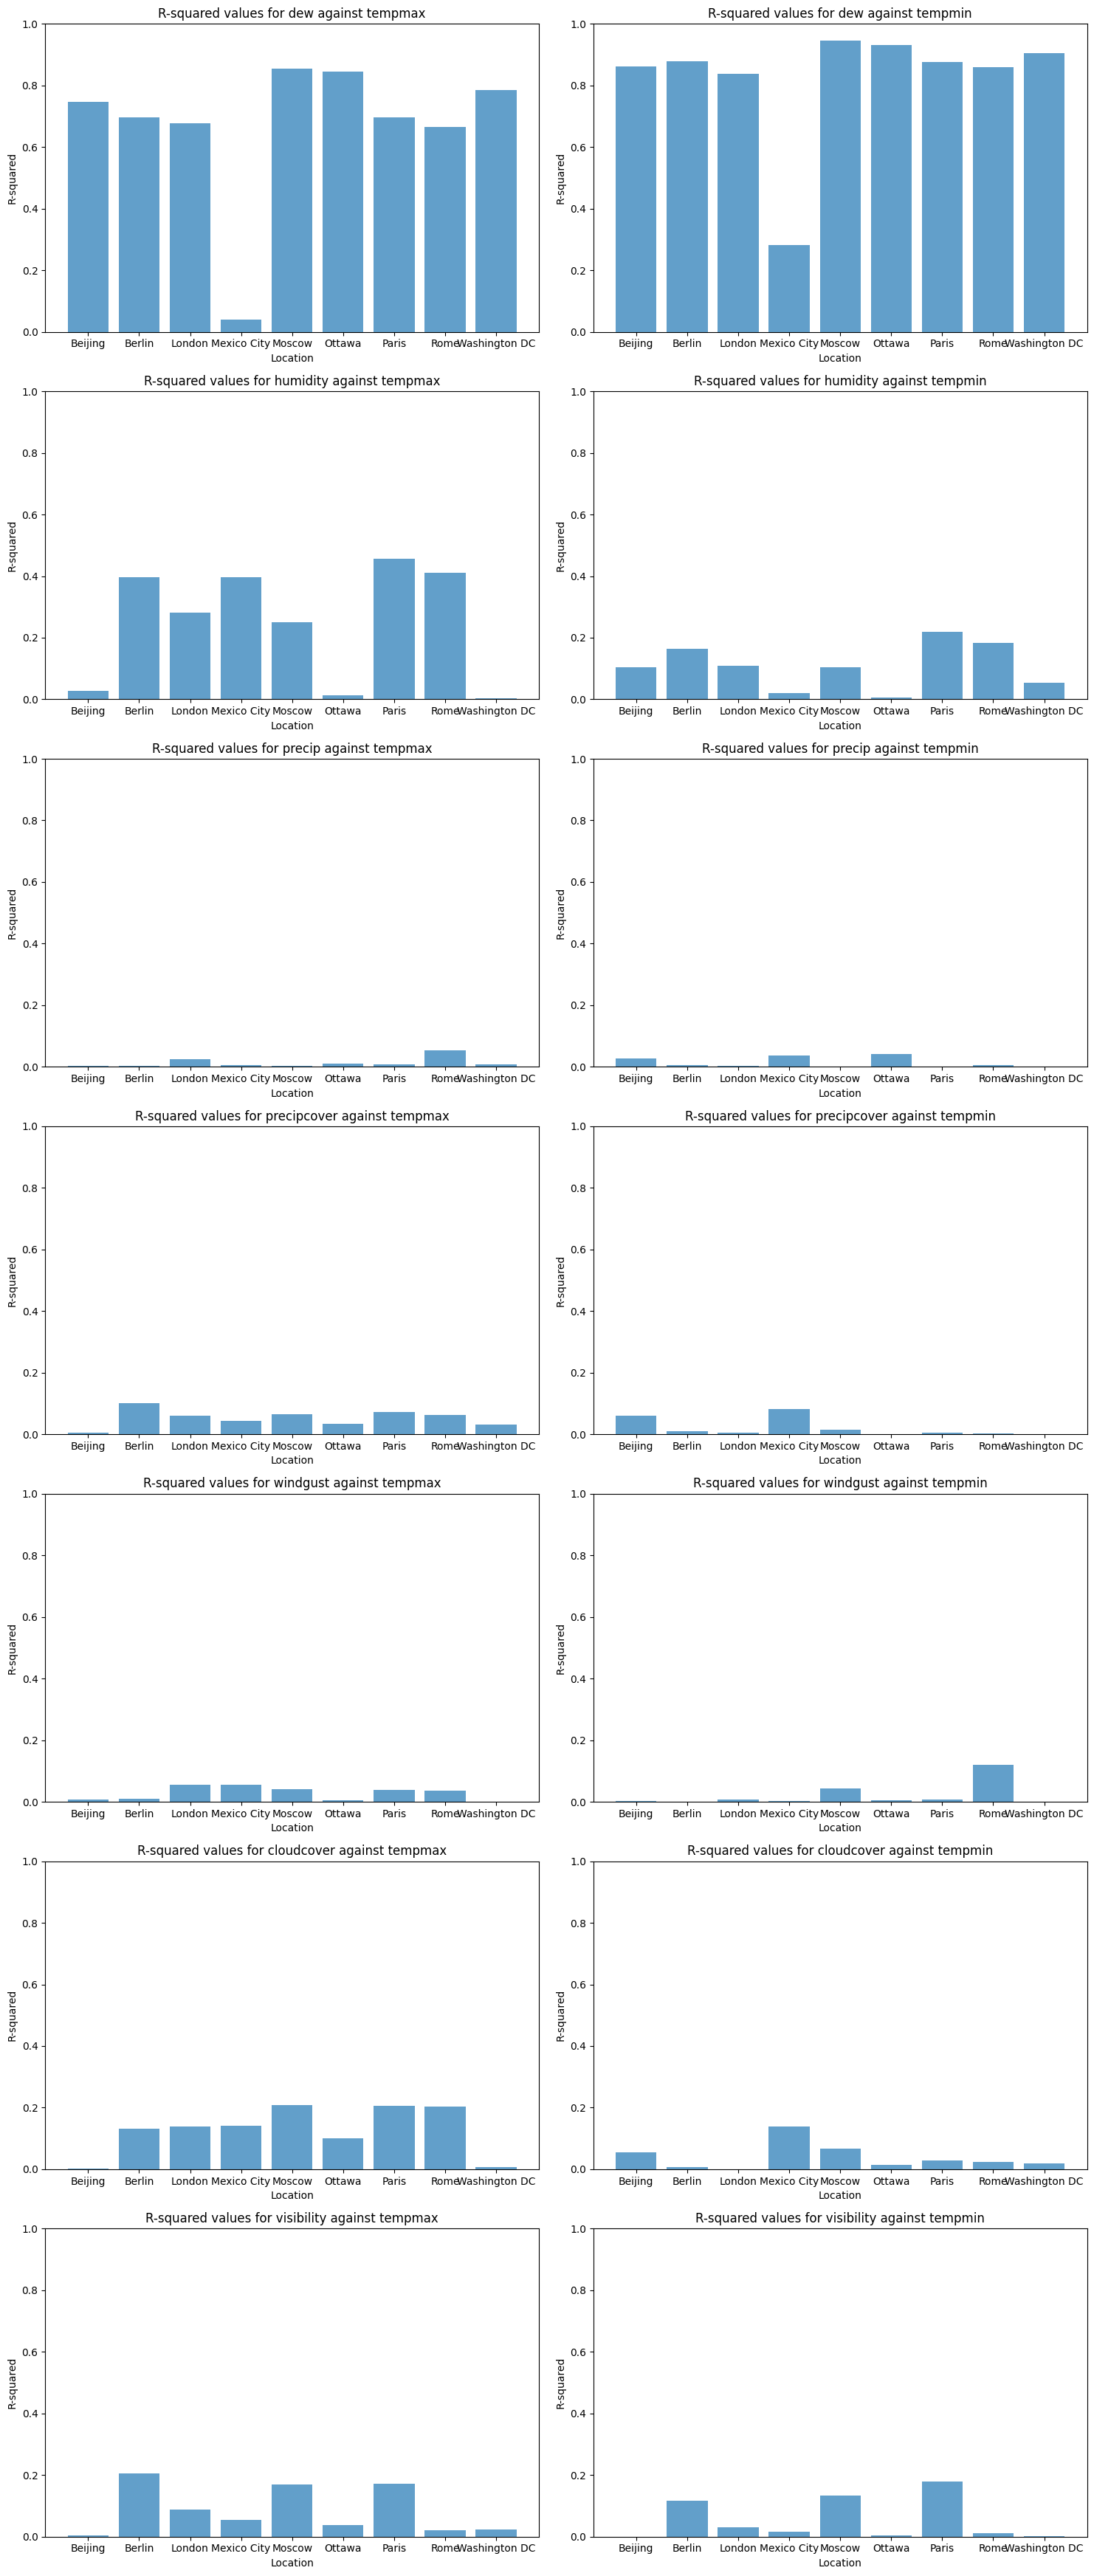

In [13]:
# Prepare data for visualization
locations = list(r_squared_results.keys())
r_squared_tempmax = {feature: [r_squared_results[loc]['tempmax'][feature] for loc in locations] for feature in features}
r_squared_tempmin = {feature: [r_squared_results[loc]['tempmin'][feature] for loc in locations] for feature in features}

# Create subplots for better visualization
fig, axes = plt.subplots(len(features), 2, figsize=(15, len(features) * 5))

# Plot for each feature against tempmax and tempmin
for idx, feature in enumerate(features):
    # Plot for tempmax
    axes[idx, 0].bar(locations, r_squared_tempmax[feature], alpha=0.7)
    axes[idx, 0].set_title(f'R-squared values for {feature} against tempmax')
    axes[idx, 0].set_ylabel('R-squared')
    axes[idx, 0].set_ylim(0, 1)  # R-squared values range from 0 to 1

    # Plot for tempmin
    axes[idx, 1].bar(locations, r_squared_tempmin[feature], alpha=0.7)
    axes[idx, 1].set_title(f'R-squared values for {feature} against tempmin')
    axes[idx, 1].set_ylabel('R-squared')
    axes[idx, 1].set_ylim(0, 1)  # R-squared values range from 0 to 1

# Set common labels and x-ticks
for ax in axes.flat:
    ax.set_xlabel('Location')
    ax.set_xticks(range(len(locations)))
    ax.set_xticklabels(locations)

plt.tight_layout()
plt.show()
plt.show()

# Predictions with Ridge Model
- First, split the data into “training” and “test” data using scikit-learn’s `train_test_split` function

In [14]:
# Training and test data
from sklearn.model_selection import train_test_split

current_df = beijing_city

# Defining the targets and features list after VIF test
features = ['dew', 'humidity', 'precip', 'precipcover', 'windgust', 'cloudcover', 'visibility']
target_max = 'tempmax'
target_min = 'tempmin'

# Split data into features (X) and target (y)
X = current_df[features]
y_max = current_df[target_max]
y_min = current_df[target_min]

# Split the data into training and testing sets
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, y_max, test_size=0.4, random_state=42)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X, y_min, test_size=0.4, random_state=42)

- import the model and score function.

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Assuming current_df is your DataFrame for Beijing
current_df = beijing_city

# Define features and targets
features = ['dew', 'humidity', 'precip', 'precipcover', 'windgust', 'cloudcover', 'visibility']
target_max = 'tempmax'
target_min = 'tempmin'

# Split data into features (X) and target (y)
X = current_df[features]
y_max = current_df[target_max]
y_min = current_df[target_min]

# Split the data into training and testing sets
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, y_max, test_size=0.2, random_state=42)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X, y_min, test_size=0.2, random_state=42)

# Define the model with the best parameters
ridge_model_max = Ridge()
ridge_model_min = Ridge()

# Create pipelines for preprocessing and modeling
pipeline_max = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge_model_max)
])

pipeline_min = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge_model_min)
])

# Define the parameter grid for GridSearchCV
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search for max temperature model
grid_search_max = GridSearchCV(pipeline_max, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_max.fit(X_train_max, y_train_max)

# Perform grid search for min temperature model
grid_search_min = GridSearchCV(pipeline_min, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_min.fit(X_train_min, y_train_min)

# Get the best models
best_pipeline_max = grid_search_max.best_estimator_
best_pipeline_min = grid_search_min.best_estimator_

# Save the best models
joblib.dump(best_pipeline_max, 'ridge_model_max.pkl')
joblib.dump(best_pipeline_min, 'ridge_model_min.pkl')

# Make predictions on the test set with the best models
y_pred_max = best_pipeline_max.predict(X_test_max)
y_pred_min = best_pipeline_min.predict(X_test_min)

# Evaluate the model's performance
mae_max = mean_absolute_error(y_test_max, y_pred_max)
mse_max = mean_squared_error(y_test_max, y_pred_max)
rmse_max = mse_max ** 0.5
r2_max = r2_score(y_test_max, y_pred_max)

mae_min = mean_absolute_error(y_test_min, y_pred_min)
mse_min = mean_squared_error(y_test_min, y_pred_min)
rmse_min = mse_min ** 0.5
r2_min = r2_score(y_test_min, y_pred_min)

print(f"Max Temperature Model - MAE: {mae_max}, MSE: {mse_max}, RMSE: {rmse_max}, R-squared: {r2_max}")
print(f"Min Temperature Model - MAE: {mae_min}, MSE: {mse_min}, RMSE: {rmse_min}, R-squared: {r2_min}")

# Function to make predictions for a specific day
def predict_specific_day_weather(new_data, prediction_date):
    # Load the saved models
    pipeline_max = joblib.load('ridge_model_max.pkl')
    pipeline_min = joblib.load('ridge_model_min.pkl')

    # Ensure new_data is a DataFrame with the same columns as the training data
    new_data = pd.DataFrame(new_data, columns=features)

    # Predict the max and min temperatures
    tempmax_pred = pipeline_max.predict(new_data)
    tempmin_pred = pipeline_min.predict(new_data)

    return prediction_date, tempmax_pred[0], tempmin_pred[0]

# Example new data for prediction (this should be in the same format as your training data)
new_data = {
    'dew': [10.5],
    'humidity': [80],
    'precip': [0],
    'precipcover': [0],
    'windgust': [20],
    'cloudcover': [50],
    'visibility': [10]
}

# Define the date for which the prediction is made
prediction_date = '2024-07-02'

# Predict the temperatures for the specific day
predicted_date, tempmax_pred, tempmin_pred = predict_specific_day_weather(new_data, prediction_date)
print(f"Prediction Date: {predicted_date}")
print(f"Predicted max temperature: {tempmax_pred}")
print(f"Predicted min temperature: {tempmin_pred}")


Max Temperature Model - MAE: 2.046546699879995, MSE: 6.178584010361793, RMSE: 2.4856757653325974, R-squared: 0.9442701873558605
Min Temperature Model - MAE: 1.8805795992904335, MSE: 7.583298557706731, RMSE: 2.7537789594858064, R-squared: 0.9336869014706194
Prediction Date: 2024-07-02
Predicted max temperature: 18.62337388615242
Predicted min temperature: 7.873618493305103


In [17]:
beijing_city[beijing_city.index == "2024-07-02"]

,location,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions,description
datetime,,,,,,,,,,,,,,,,,,,,,
2024-07-02,Beijing,26.0,18.0,22.9,26.0,18.0,22.9,17.3,72.3,4.3,...,0.0,30.6,18.0,3.0,1003.5,100.0,9.8,0.86,"Rain, Overcast",Cloudy skies throughout the day with rain.


In [18]:
sub_beijing = beijing_city.copy()
sub_beijing = sub_beijing[['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase']]

In [19]:
sub_beijing.dtypes
sub_beijing["precipprob"] = sub_beijing.

tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
precipcover         float64
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
moonphase           float64
dtype: object

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Define features and target
columns_to_drop = ['tempmax', 'tempmin']
features = sub_beijing.drop(columns=[col for col in columns_to_drop if col in sub_beijing.columns])
target_max = sub_beijing['tempmax']
target_min = sub_beijing['tempmin']

# Split the data into training and testing sets
X_train, X_test, y_train_max, y_test_max = train_test_split(features, target_max, test_size=0.2, random_state=42)
X_train, X_test, y_train_min, y_test_min = train_test_split(features, target_min, test_size=0.2, random_state=42)

# Train the model for tempmax
ridge_max = Ridge()
ridge_max.fit(X_train, y_train_max)

# Train the model for tempmin
ridge_min = Ridge()
ridge_min.fit(X_train, y_train_min)

# Predict tempmax and tempmin for the test set
y_pred_max = ridge_max.predict(X_test)
y_pred_min = ridge_min.predict(X_test)

# Create the prediction columns if they don't exist
if 'predicted_tempmax' not in sub_beijing.columns:
    sub_beijing['predicted_tempmax'] = None

if 'predicted_tempmin' not in sub_beijing.columns:
    sub_beijing['predicted_tempmin'] = None

# Fill NaN values with 0
sub_beijing.fillna({'predicted_tempmax': 0, 'predicted_tempmin': 0}, inplace=True)

# Add predictions to the original dataframe
sub_beijing.loc[X_test.index, 'predicted_tempmax'] = y_pred_max
sub_beijing.loc[X_test.index, 'predicted_tempmin'] = y_pred_min

# Ensure alignment by resetting the indices
beijing_df = sub_beijing.sort_index()

# Optional: Calculate and print the mean squared error for evaluation
mse_max = mean_squared_error(y_test_max, y_pred_max)
mse_min = mean_squared_error(y_test_min, y_pred_min)

print(f'Mean Squared Error for tempmax: {mse_max}')
print(f'Mean Squared Error for tempmin: {mse_min}')

# Display the dataframe with predictions
print(beijing_df[['tempmax', 'predicted_tempmax', 'tempmin', 'predicted_tempmin']])


Mean Squared Error for tempmax: 0.9481648458296917
Mean Squared Error for tempmin: 0.9746217850671186
            tempmax  predicted_tempmax  tempmin  predicted_tempmin
datetime                                                          
2023-05-01     25.2          25.269021      8.0           9.265838
2023-05-02     29.0           0.000000     15.8           0.000000
2023-05-03     28.0           0.000000     14.0           0.000000
2023-05-04     22.0           0.000000     15.0           0.000000
2023-05-05     19.0           0.000000     16.7           0.000000
...             ...                ...      ...                ...
2024-07-03     31.0          30.947325     18.7          19.078634
2024-07-04     32.5          32.054027     22.9          22.932937
2024-07-05     36.4           0.000000     23.1           0.000000
2024-07-06     29.0           0.000000     23.6           0.000000
2024-07-07     37.5           0.000000     23.5           0.000000

[434 rows x 4 columns]


In [23]:
sub_beijing

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,predicted_tempmax,predicted_tempmin
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-01,25.2,8.0,18.1,25.2,8.0,18.1,8.1,54.7,0.0,0,...,0.0,36.4,21.6,110.5,1009.6,54.2,10.4,0.35,25.269021,9.265838
2023-05-02,29.0,15.8,22.3,27.9,15.8,22.1,10.4,48.9,0.0,0,...,0.0,37.4,21.6,133.7,1008.3,26.0,10.6,0.39,0.000000,0.000000
2023-05-03,28.0,14.0,21.2,27.6,14.0,21.1,12.4,59.4,0.0,0,...,0.0,30.6,18.0,122.7,1011.3,62.2,10.1,0.42,0.000000,0.000000
2023-05-04,22.0,15.0,17.8,22.0,15.0,17.8,14.0,79.1,0.1,100,...,0.0,28.8,14.4,99.7,1009.2,85.1,8.4,0.45,0.000000,0.000000
2023-05-05,19.0,16.7,17.8,19.0,16.7,17.8,9.5,61.9,1.1,100,...,0.0,46.8,28.8,5.6,1009.1,95.8,11.4,0.48,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-03,31.0,18.7,24.9,30.3,18.7,24.8,14.5,54.9,0.0,45,...,0.0,14.8,14.4,162.4,1004.8,65.7,22.9,0.90,30.947325,19.078634
2024-07-04,32.5,22.9,27.3,33.4,22.9,27.8,18.3,59.1,1.8,67,...,0.0,16.2,13.3,147.2,1004.0,63.3,23.4,0.94,32.054027,22.932937
2024-07-05,36.4,23.1,29.5,37.7,23.1,30.1,18.2,52.9,1.1,54,...,0.0,24.1,16.2,182.7,1000.6,84.7,24.1,0.97,0.000000,0.000000


In [21]:
sub_beijing.isnull().sum()

tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
moonphase            0
predicted_tempmax    0
predicted_tempmin    0
dtype: int64